In [1]:
import json
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Resizing
from keras.optimizers import Adam
import tensorflow as tf

In [2]:
def split_image(image, chunk_size):
    h, w = image.shape[:2]
    cw, ch = chunk_size
    if h % ch != 0 or w % cw != 0:
        raise ValueError(f"Image size {w}x{h} not divisible by chunk size {cw}x{ch}")
    chunks = []
    for y in range(0, h, ch):
        for x in range(0, w, cw):
            chunk = image[y:y+ch, x:x+cw]
            chunks.append(chunk / 255.0)
    return np.array(chunks)


def merge_chunks(chunks, image_size, chunk_size):
    h, w = image_size
    cw, ch = chunk_size
    full_image = np.zeros((h, w, 3))
    idx = 0
    for y in range(0, h, ch):
        for x in range(0, w, cw):
            full_image[y:y+ch, x:x+cw] = chunks[idx]
            idx += 1
    return full_image


In [3]:
def image_chunk_generator(
    coco_json_path,
    clean_root_prefix,
    corruption_root,
    corruption_type="fog",
    severity_level=2,
    chunk_size=(200, 150),
    full_size=(1600, 900)
):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    for img_info in coco_data['images']:
        relative_path = img_info['file_name']
        clean_path = os.path.join(clean_root_prefix, relative_path)

        base_name = os.path.splitext(os.path.basename(relative_path))[0]
        camera_dir = os.path.basename(os.path.dirname(relative_path))
        corrupted_fname = f"{base_name}_{corruption_type}_{severity_level}.jpg"
        corrupted_path = os.path.join(corruption_root, camera_dir, corrupted_fname)

        clean = cv2.imread(clean_path)
        corrupted = cv2.imread(corrupted_path)

        if clean is None or corrupted is None:
            continue

        clean = cv2.resize(clean, full_size)
        corrupted = cv2.resize(corrupted, full_size)

        clean_chunks = split_image(clean, chunk_size)
        corrupted_chunks = split_image(corrupted, chunk_size)

        for c_chunk, cl_chunk in zip(corrupted_chunks, clean_chunks):
            yield c_chunk.astype(np.float32), cl_chunk.astype(np.float32)

In [4]:
def get_datasets(coco_json_path, clean_root_prefix, corruption_root,
                 corruption_type="fog", severity_level=2,
                 chunk_size=(200, 150), full_size=(1600, 900),
                 batch_size=32, val_split=0.1):

    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    images = coco_data['images']
    n_total = len(images)
    n_val = int(n_total * val_split)

    # Instead of shuffling all, just slice deterministically
    train_images = images[:-n_val]
    val_images = images[-n_val:]

    output_signature = (
        tf.TensorSpec(shape=(chunk_size[1], chunk_size[0], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(chunk_size[1], chunk_size[0], 3), dtype=tf.float32)
    )

    train_ds = tf.data.Dataset.from_generator(
        lambda: image_chunk_generator(coco_json_path, clean_root_prefix, corruption_root,
                                      corruption_type, severity_level, chunk_size, full_size),
        output_signature=output_signature
    )

    # Shuffle only a buffer, not entire dataset
    train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_generator(
        lambda: image_chunk_generator(coco_json_path, clean_root_prefix, corruption_root,
                                      corruption_type, severity_level, chunk_size, full_size),
        output_signature=output_signature
    ).skip(len(train_images)).take(n_val).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

In [5]:
def load_images_from_coco_json(
    coco_json_path,
    clean_root_prefix,
    corruption_root,
    corruption_type="fog",
    severity_level=2,
    chunk_size=(200, 150),
    full_size=(1600, 900)
):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    corrupted_chunks, clean_chunks = [], []

    for img_info in coco_data['images']:
        relative_path = img_info['file_name']
        clean_path = os.path.join(clean_root_prefix, relative_path)

        base_name = os.path.splitext(os.path.basename(relative_path))[0]
        camera_dir = os.path.basename(os.path.dirname(relative_path))

        corrupted_fname = f"{base_name}_{corruption_type}_{severity_level}.jpg"
        corrupted_path = os.path.join(corruption_root, camera_dir, corrupted_fname)

        clean = cv2.imread(clean_path)
        corrupted = cv2.imread(corrupted_path)

        if clean is not None and corrupted is not None:
            clean = cv2.resize(clean, full_size)
            corrupted = cv2.resize(corrupted, full_size)
            clean_chunks.extend(split_image(clean, chunk_size))
            corrupted_chunks.extend(split_image(corrupted, chunk_size))

    return np.array(corrupted_chunks), np.array(clean_chunks), coco_data


In [6]:
def weighted_mse(y_true, y_pred):
    r_loss = tf.reduce_mean(tf.square(y_true[..., 0] - y_pred[..., 0]))
    g_loss = tf.reduce_mean(tf.square(y_true[..., 1] - y_pred[..., 1]))
    b_loss = tf.reduce_mean(tf.square(y_true[..., 2] - y_pred[..., 2]))
    return 0.5 * r_loss + 0.5 * g_loss + 0.5 * b_loss

def color_weighted_mse(y_true, y_pred):
    """
    Custom loss that penalizes color differences more heavily.
    y_true, y_pred: tensors of shape (batch, height, width, 3) in RGB [0,1]
    """
    # Ensure values are in [0,1]
    y_true = tf.clip_by_value(y_true, 0.0, 1.0)
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)

    # Convert RGB to HSV for better color separation
    y_true_hsv = tf.image.rgb_to_hsv(y_true)
    y_pred_hsv = tf.image.rgb_to_hsv(y_pred)

    # Compute per-pixel color difference in HSV space
    hue_diff = tf.abs(y_true_hsv[..., 0] - y_pred_hsv[..., 0])
    sat_diff = tf.abs(y_true_hsv[..., 1] - y_pred_hsv[..., 1])
    val_diff = tf.abs(y_true_hsv[..., 2] - y_pred_hsv[..., 2])

    # Weight hue differences more heavily (color mismatch)
    color_weight = 2.0 * hue_diff + 1.0 * sat_diff + 0.5 * val_diff

    # Base pixel-wise MSE in RGB
    base_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)

    # Apply color weighting
    weighted_loss = base_mse * (1.0 + color_weight)

    # Return mean loss over batch
    return tf.reduce_mean(weighted_loss)

In [7]:

def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    h, w = input_shape[:2]

    # Encoder
    x = Conv2D(64, (3, 3), activation=None, padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation=None, padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Force output to match input shape
    x = Resizing(h, w)(x)

    autoencoder = Model(input_img, x)
    autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")
    return autoencoder




In [8]:

def show_full_image_result(model, corrupted_img, clean_img, chunk_size=(200, 150)):
    corrupted_chunks = split_image(corrupted_img, chunk_size)
    predicted_chunks = model.predict(corrupted_chunks)
    
    reconstructed_img = merge_chunks(predicted_chunks, corrupted_img.shape[:2], chunk_size)


    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.title("Corrupted")
    plt.imshow(corrupted_img[..., ::-1] / 255.0)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Clean")
    plt.imshow(clean_img[..., ::-1] / 255.0)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Denoised")
    plt.imshow(reconstructed_img[..., ::-1])
    plt.axis('off')
    plt.show()


In [9]:
def train_autoencoder(
    coco_json_path,
    clean_root_prefix,
    corruption_root,
    corruption_type="fog",
    severity_level=2,
    chunk_size=(200, 150),
    full_size=(1600, 900),
    epochs=50,
    batch_size=32,
    weights_dir="weights",
):
    os.makedirs(weights_dir, exist_ok=True)
    weight_path = os.path.join(weights_dir, f"autoencoder_{corruption_type}_{severity_level}.weights.h5")

    train_ds, val_ds = get_datasets(
        coco_json_path, clean_root_prefix, corruption_root,
        corruption_type, severity_level, chunk_size, full_size,
        batch_size, val_split=0.1
    )

    # Peek one batch to build model
    sample_batch = next(iter(train_ds))
    autoencoder = build_autoencoder(sample_batch[0].shape[1:])

    if os.path.exists(weight_path):
        print(f"Loading model weights from {weight_path}")
        autoencoder.load_weights(weight_path)
    else:
        print("Training new model...")
        autoencoder.fit(train_ds, validation_data=val_ds, epochs=epochs)
        autoencoder.save_weights(weight_path)
        print(f"Model weights saved to {weight_path}")


    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    sample_clean = cv2.imread(os.path.join(clean_root_prefix, coco_data['images'][0]['file_name']))
    sample_corrupted = cv2.imread(os.path.join(corruption_root, os.path.basename(os.path.dirname(coco_data['images'][0]['file_name'])), f"{os.path.splitext(os.path.basename(coco_data['images'][0]['file_name']))[0]}_{corruption_type}_{severity_level}.jpg"))
    sample_clean = cv2.resize(sample_clean, full_size)
    sample_corrupted = cv2.resize(sample_corrupted, full_size)
    show_full_image_result(autoencoder, sample_corrupted, sample_clean, chunk_size)

    return autoencoder


## Configuration

In [10]:
coco_json_path="../data/sets/nuimages/nuimages_1k.json"
clean_root_prefix="../data/sets/nuimages"
corruption_type = "fog"
corruption_root=f"../data/sets/generated/nuimages-1k/{corruption_type}"
severity_level = 3


Training new model...
Epoch 1/8
   1500/Unknown 489s 325ms/step - loss: 0.0286

c:\Users\srv33\Desktop\Works\week02\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 490s 326ms/step - loss: 0.0132 - val_loss: 0.0057
Epoch 2/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 491s 326ms/step - loss: 0.0026 - val_loss: 0.0050
Epoch 3/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 491s 327ms/step - loss: 0.0021 - val_loss: 0.0050
Epoch 4/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 490s 326ms/step - loss: 0.0018 - val_loss: 0.0042
Epoch 5/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 491s 326ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 6/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 491s 326ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 7/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 491s 327ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 8/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 510s 339ms/step - loss: 0.0013 - val_loss: 0.0038
Model weights saved to weights\autoencoder_fog_3.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


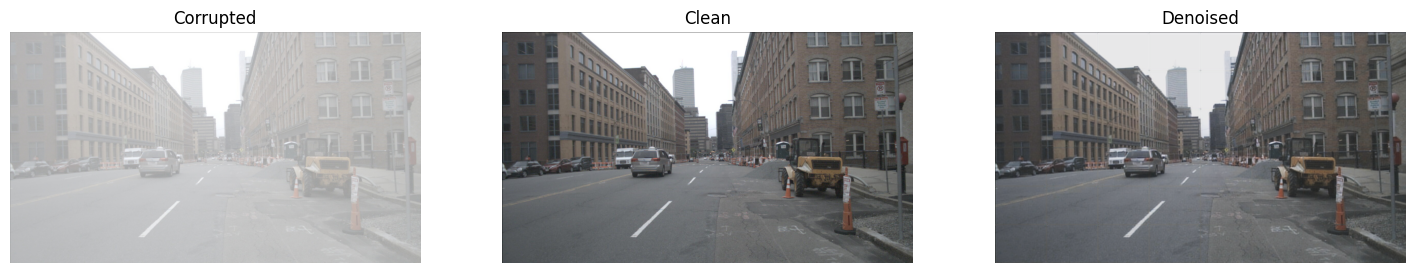

In [11]:
# Example usage
if __name__ == "__main__":
    model = train_autoencoder(
        coco_json_path=coco_json_path,
        clean_root_prefix=clean_root_prefix,
        corruption_root=corruption_root,
        corruption_type=corruption_type,
        severity_level=severity_level,
        full_size=(1600, 900),
        chunk_size=(200, 150),
        epochs=8,
        batch_size=32
    )